# Polatization state 3D animations [WIP]

This notebook produces a set of 3D animations representing gravitational waves (GWs) with different polarization states: linear, circular or elliptical. **This is a work in progress.**

Begin with some basic imports and settings.

In [1]:
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [2]:
import seaborn as sns
from matplotlib.patches import Circle, Wedge, Polygon
from utils.plots import EllipticalWedge
from utils.pols import *
import imageio
import warnings

sns.set(context='notebook', palette='colorblind', style='ticks',
        font='serif', font_scale=1.5)

# suppress some annoying warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

plt.rcParams["text.usetex"] = "true"

## Spherical animation

In [3]:
from pyspherical import spin_spherical_harmonic

In [9]:
# define source-centered Cartesian frame {X, Y, Z} based on which to 
# define Ylm's
X = array([1, 0, 0])
Y = array([0, 1, 0])
Z = array([0, 0, 1])

# the wave propagation vector will be
def wave_nhat(theta, phi):
    n = [sin(theta)*cos(phi), sin(theta)*sin(phi), cos(theta)]
    return array(n)

# define polarization axes X and Y following LIGO convention
# https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group___l_a_l_simulation__h.html
# https://lscsoft.docs.ligo.org/lalsuite/lalsimulation/group__lalsimulation__inspiral.html
def wave_xy(theta=None, phi=None, nhat=None):
    if nhat is None:
        nhat = wave_nhat(theta, phi)
    # the x vector will be n x Z
    if nhat[2] == 1:
        # theta = 0 so there's ambiguity about frame orientation,
        # disambiguate manually
        x = array([cos(phi), sin(phi), 0])
    else:
        x = cross(nhat, Z)
    # the y vector is n x x
    y = cross(nhat, x)
    return x/linalg.norm(x), y/linalg.norm(y)

def get_ring(theta=None, phi=None, nhat=None, npoints=16, r=0.1):
    # distribute `npoints` points in a circle around the sky location 
    # defined by theta and phi, with radius `r` around the center
    n = nhat if nhat is not None else wave_nhat(theta, phi)
    x, y = wave_xy(theta, phi, n)
    # compute angular separation between points
    angle = 2*pi / npoints
    # first point will be anchored in the direction of the waveframe x
    points = [r*x]
    # now rotate that initial point `npoints` times around nhat
    # to do that, first define a rotation matrix around n
    # (this is simply a composition of matrices rotating aroung X, Y, Z,
    # but let's code up the resulting matrix---lifted from Wikipedia---
    # directly to make this more efficient
    costh, sinth = cos(angle), sin(angle)
    p = 1 - costh
    R = array([[costh + n[0]*n[0]*p,      n[0]*n[1]*p - n[2]*sinth, n[0]*n[2]*p + n[1]*sinth],
                [n[0]*n[1]*p + n[2]*sinth, costh + n[1]*n[1]*p,      n[1]*n[2]*p - n[0]*sinth],
                [n[0]*n[2]*p - n[1]*sinth, n[2]*n[1]*p + n[0]*sinth, costh + n[2]*n[2]*p]])
    # we can now apply the rotation iteratively
    for i in range(1, npoints):
        points.append(dot(R, points[i-1]))
    return array(points)

def get_epec(theta=None, phi=None, nhat=None):
    x, y = wave_xy(theta, phi, nhat)
    ep = outer(x, x) - outer(y, y)
    ec = outer(x, y) + outer(y, x)
    return ep, ec    

In [10]:
# functions to lay down Fibonacci grid on the sphere

def cartesian_to_spherical(xyz, north_polar=True):
    """ Efficiently convert points from Carstesian to spherical coordinates.

    https://stackoverflow.com/questions/4116658/faster-numpy-cartesian-to-spherical-coordinate-conversion
    """
    ptsnew = np.zeros(xyz.shape)
    xy = xyz[:,0]**2 + xyz[:,1]**2
    # radius
    ptsnew[:,0] = np.sqrt(xy + xyz[:,2]**2)
    if north_polar:
        # elevation (polar) angle defined from Z-axis down
        ptsnew[:,1] = np.arctan2(np.sqrt(xy), xyz[:,2])
    else:
        # elevation (polar) angle defined from XY-plane up
        ptsnew[:,1] = np.arctan2(xyz[:,2], np.sqrt(xy))
    # azimuthal angle from x-axis
    ptsnew[:,2] = np.arctan2(xyz[:,1], xyz[:,0])
    return ptsnew


def fibonacci_sphere(samples, randomize=False, spherical=True, **kwargs):
    """ Create a Fibonacci grid on the unit sphere.

    https://stackoverflow.com/questions/9600801/evenly-distributing-n-points-on-a-sphere

    Arguments
    ---------
    samples : int
        number of points to draw
    randomize : bool

    Returns
    -------
    points : array
        [x, y, z] or [r, theta, phi] or [r, np.pi-theta, phi]
    """
    rnd = 1.
    if randomize:
        rnd = random.random() * samples
    points = []
    offset = 2./samples
    increment = np.pi * (3. - np.sqrt(5.));
    for i in range(samples):
        y = ((i * offset) - 1) + (offset / 2);
        r = np.sqrt(1 - pow(y, 2))
        phi = ((i + rnd) % samples) * increment
        x = np.cos(phi) * r
        z = np.sin(phi) * r
        points.append([x,y,z])
    points = np.array(points)
    if spherical:
        points = cartesian_to_spherical(points, **kwargs)
    return points

In [11]:
# fig = plt.figure()
# ax = fig.add_subplot(projection='3d')

# th, phi = pi/2, 3*pi/2
# ps = get_ring(th, phi)
# n = wave_nhat(th, phi)
# ps += n

# ax.scatter(ps[:,0], ps[:,1], ps[:,2])

# na = vstack([zeros(3), n])
# ax.plot(na[:,0], na[:,1], na[:,2])

In [12]:
def sphere_snap(wt, nsphere=56, ncircle=16, rcircle=0.5, rsphere=5):
    # let's pick a number of points in the sphere to serve as centers
    # to our little rings (these are just nhats in spherical coordinates)
    nhats_sph = fibonacci_sphere(nsphere)

    # let's produce a ring around each of these sky locations
    rings = [get_ring(theta, phi, npoints=ncircle, r=rcircle) for _, theta, phi in nhats_sph]


    nhats_xyz = rsphere*fibonacci_sphere(nsphere, spherical=False)

    el, em = 2, 2
    A = 1

    fig = plt.figure(dpi=150)
    ax = fig.add_subplot(projection='3d')
    
    cmap = matplotlib.cm.get_cmap('magma')
    norm = matplotlib.colors.Normalize(vmin=-A, vmax=A)
    
    for a in [X,Y,Z]:
        p = vstack([zeros(3), a])
        plot(p[:,0], p[:,1], p[:,2], c='gray')
        
#     # Make sphere data
#     u = np.linspace(0, 2 * np.pi, 100)
#     v = np.linspace(0, np.pi, 100)
#     x = 0.95 *rsphere * np.outer(np.cos(u), np.sin(v))
#     y = 0.95 *rsphere * np.outer(np.sin(u), np.sin(v))
#     z = 0.95 *rsphere * np.outer(np.ones(np.size(u)), np.cos(v))

#     # Plot the surface
#     ax.plot_surface(x, y, z, color='b', lw=0)

    ax.scatter(nhats_xyz[:,0], nhats_xyz[:,1], nhats_xyz[:,2], marker='.', s=1, color='k')
    for n, nsph, ring in zip(nhats_xyz, nhats_sph, rings):
        _, theta, phi = nsph

        h = A * spin_spherical_harmonic(-2, el, em, theta, phi)*exp(-1j*em*wt) + \
            (-1)**el * A * spin_spherical_harmonic(-2, el, -em, theta, phi)*exp(1j*em*wt)
        ep, ec = get_epec(theta, phi)

        dx = dot(h.real*ep - h.imag*ec, ring.T).T

        new_ring = ring + dx
        ps = n + new_ring
        ax.plot(ps[:,0], ps[:,1], ps[:,2], color=cmap(abs(h)), lw=1)

    ax.set_box_aspect((1, 1, 1))
    ax.axis('off')
    return fig

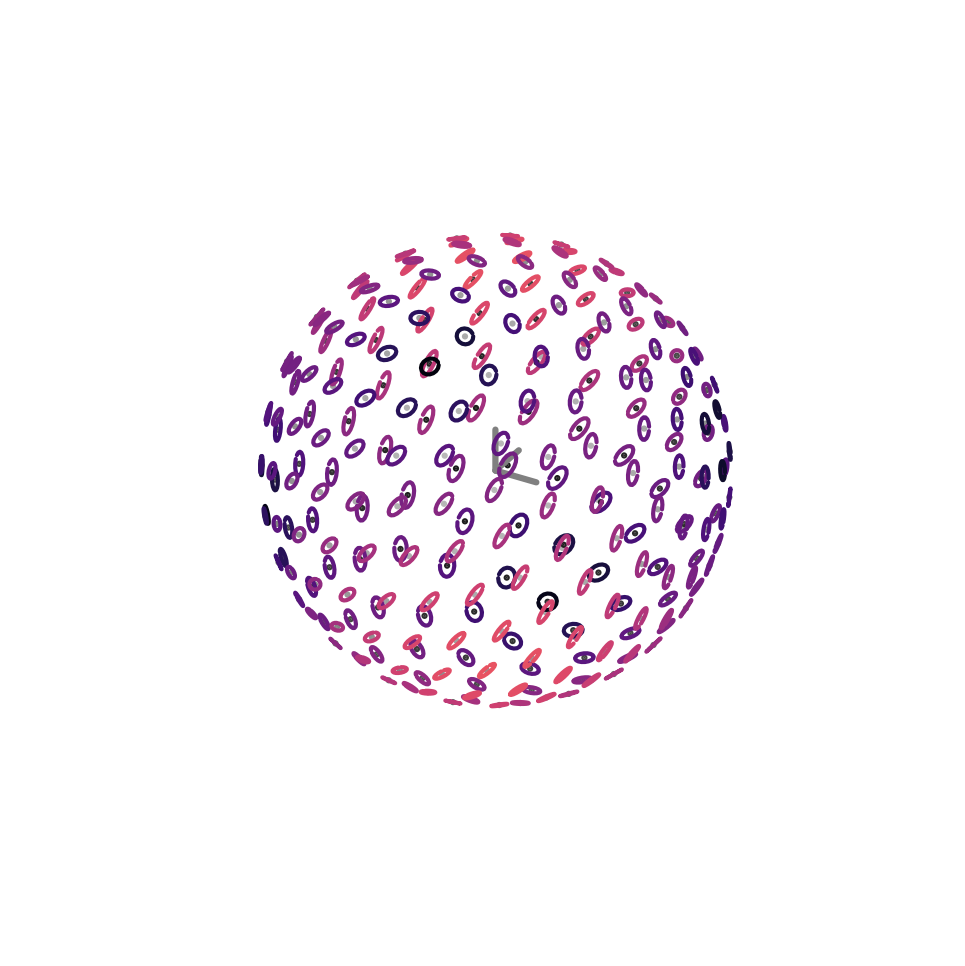

In [13]:
for wt in linspace(0, 2*pi, 1):
    sphere_snap(wt, nsphere=256, rcircle=0.2);

In [ ]:
def get_sphere_snap(*args, **kws):
    fig = sphere_snap(*args, **kws);
    
    # Used to return the plot as an image rray
    fig.canvas.draw()       # draw the canvas, cache the renderer
    image = np.frombuffer(fig.canvas.tostring_rgb(), dtype='uint8')
    image  = image.reshape(fig.canvas.get_width_height()[::-1] + (3,))

    return image

In [ ]:
nfs = 50
figlist = []
for wt in linspace(0, 2*pi, nfs):
    figlist.append(get_sphere_snap(wt, nsphere=256, rcircle=0.2))
    plt.close()
imageio.mimsave('sphere_22.gif', figlist, fps=12);

## License

Copyright 2022 Maximiliano Isi max.isi@ligo.org

This program is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation; either version 2 of the License, or (at your option) any later version.

This program is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details.

You should have received a copy of the GNU General Public License along with this program; if not, write to the Free Software Foundation, Inc., 51 Franklin Street, Fifth Floor, Boston, MA 02110-1301, USA.